In [1251]:
#Import packages
import numpy as np
from scipy.stats import norm
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import random

## Data Wrangling

In [1268]:
#Read csv files and make both sets have same column names
SRCFB = pd.read_csv('Results_New.csv')
ELO = pd.read_csv('ELO_New.csv')
SRCFB.rename(columns={'School': 'Team'}, inplace=True)


#Drop all unamed columns from elo and all N/A values bc elo should have no N/A
df = ELO.loc[:, ~ELO.columns.str.contains('^Unnamed')]
df = df.dropna()

#Drop all unamed columns in SRCFB and remove unecessary columns
#Remove N/A values from all rows below 398
SRCFB = SRCFB.loc[:, ~SRCFB.columns.str.contains('^Unnamed')]
SRCFB = SRCFB.drop(['Sorted Sheet1', 'Sorted Sheet2'], axis=1)
SRCFB = SRCFB.iloc[:398]

#Inner join sets on team and year
master = pd.merge(SRCFB, ELO, on=['Team', 'Year'], how='inner')

#Sort by a-z to check validity of merge
master = master.sort_values(by='Team', ascending=True)

#Remove unamed columns again
master = master.loc[:, ~master.columns.str.contains('^Unnamed')]

#Export to csv for future acess
master.to_csv('master401.csv', index=False)

#master

In [1269]:
ELO_avg = master.groupby('Team', as_index=False)['ELO'].mean()

ELO_avg.to_csv('ELO_avg.csv', index=False)

# Display the new DataFrame
#ELO_avg

https://blog.collegefootballdata.com/talking-tech-elo-ratings/

https://blog.collegefootballdata.com/talking-tech-elo-ratings/

## Making Starting Relegation Groups

In [1270]:
# sort by elo
pnl = ELO_avg.sort_values(by='ELO', ascending=False)

tier1 = pnl.head(34)
tier1.reset_index(drop=True, inplace=True)
pnl = pnl.tail(100)


tier2 = pnl.head(34)
tier2.reset_index(drop=True, inplace=True)
pnl = pnl.tail(66)


tier3 = pnl.head(34)
tier3.reset_index(drop=True, inplace=True)
pnl = pnl.tail(32)


tier4 = pnl.head(32)
tier4.reset_index(drop=True, inplace=True)



## DO NOT DELETE BELOW HERE

## Sim Game Function

In [1271]:
def simgame(team1, home_rating, team2, away_rating):
    def get_expected_score(home_rating, away_rating):
        exp = (away_rating - home_rating) / 400
        return 1 / (1 + 10**exp)

    # Calculate win probability for team1
    wp = get_expected_score(home_rating, away_rating) * 1000
    # Generate random number and simulate game outcome
    rn = random.uniform(0, 1000)
    margin = 1 if rn <= wp else 0  # 1 if team1 wins, else 0

    # Determine the winner
    winner = team1 if margin == 1 else team2

    # Calculate new ELOs
    def get_new_elos(home_rating, away_rating, margin):
        k = 50
        home_score = margin
        away_score = 1 - home_score

        new_home_score = home_rating + k * (home_score - get_expected_score(home_rating, away_rating))
        new_away_score = away_rating + k * (away_score - get_expected_score(away_rating, home_rating))

        return round(new_home_score), round(new_away_score)

    new_home_elo, new_away_elo = get_new_elos(home_rating, away_rating, margin)

    return winner, new_home_elo, new_away_elo

## DONT DELETE

In [1272]:
def simulate_season(tier1):
    # Initialize the results DataFrame
    results = pd.DataFrame({
        'Team': tier1['Team'],
        'Wins': 0,
        'Losses': 0,
        'Starting ELO': tier1['ELO'],
        'Current ELO': tier1['ELO'],
        'Starting Rank': tier1['ELO'].rank(ascending=False, method='min').astype(int)
    })

    # Prepare list to collect each week's matchups
    matchup_results = []

    # Simulate 12 weeks
    for week in range(12):
        # Rank teams based on their current Elo for matchups
        results['Current Rank'] = results['Current ELO'].rank(ascending=False, method='min').astype(int)
        results = results.sort_values(by='Current Rank').reset_index(drop=True)

        # Pair up teams based on ranking and simulate games
        for i in range(0, len(results), 2):
            if i + 1 < len(results):  # Ensure there's a team to pair with
                team1 = results.iloc[i]['Team']
                home_rating = results.iloc[i]['Current ELO']

                team2 = results.iloc[i + 1]['Team']
                away_rating = results.iloc[i + 1]['Current ELO']

                # Simulate the game and determine the winner
                winner, new_home_elo, new_away_elo = simgame(team1, home_rating, team2, away_rating)

                # Update Wins and Losses
                if winner == team1:
                    results.loc[i, 'Wins'] += 1
                    results.loc[i + 1, 'Losses'] += 1
                else:
                    results.loc[i, 'Losses'] += 1
                    results.loc[i + 1, 'Wins'] += 1

                # Update ELOs for both teams
                results.loc[i, 'Current ELO'] = new_home_elo
                results.loc[i + 1, 'Current ELO'] = new_away_elo

                # Record the matchup and result
                matchup_results.append({
                    'Week': week + 1,
                    'Matchup': f"{team1} vs {team2}",
                    'Winning Team': winner,
                    'Team 1 ELO Before': home_rating,
                    'Team 2 ELO Before': away_rating,
                    'CBR': abs(home_rating - away_rating)
                })

    # Add final ELO and ranking columns
    results['Week 12 ELO'] = results['Current ELO']
    results['Week 12 Rank'] = results['Current ELO'].rank(ascending=False, method='min').astype(int)

    # Final results DataFrame
    final_results = results[['Team', 'Wins', 'Losses', 'Starting ELO', 'Week 12 ELO', 'Starting Rank', 'Week 12 Rank']]

    # Matchup results DataFrame
    matchup_df = pd.DataFrame(matchup_results)

    return final_results, matchup_df

# Example usage:
final_results, matchup_df = simulate_season(tier1)

#final_results
#matchup_df

## All Simulations Start Key

In [1273]:
# tier 1 results
final_results, matchup_df = simulate_season(tier1)
# tier 2 results
final_results2, matchup_df2 = simulate_season(tier2)
# tier 3 results
final_results3, matchup_df3 = simulate_season(tier3)
# tier 4 results
final_results4, matchup_df4 = simulate_season(tier4)


## Summary Stats

In [1274]:
average_CBR = matchup_df['CBR'].mean()
average_CBR2 = matchup_df2['CBR'].mean()
average_CBR3 = matchup_df3['CBR'].mean()
average_CBR4 = matchup_df4['CBR'].mean()

maxelo = final_results['Week 12 ELO'].max()
maxelo2 = final_results2['Week 12 ELO'].max()
maxelo3 = final_results3['Week 12 ELO'].max()
maxelo4 = final_results4['Week 12 ELO'].max()

minelo = final_results['Week 12 ELO'].min()
minelo2 = final_results2['Week 12 ELO'].min()
minelo3 = final_results3['Week 12 ELO'].min()
minelo4 = final_results4['Week 12 ELO'].min()



print("Tier 1 Max ELO:", maxelo)
print("Tier 1 Min ELO:", minelo)
print("Tier 2 Max ELO:", maxelo2)
print("Tier 2 Min ELO:", minelo2)
print("Tier 3 Max ELO:", maxelo3)
print("Tier 3 Min ELO:", minelo3)
print("Tier 4 Max ELO:", maxelo4)
print("Tier 4 Min ELO:", minelo4)




Tier 1 Max ELO: 1853.0
Tier 1 Min ELO: 1428.0
Tier 2 Max ELO: 1742.0
Tier 2 Min ELO: 1346.0
Tier 3 Max ELO: 1696.0
Tier 3 Min ELO: 1271.0
Tier 4 Max ELO: 1592.0
Tier 4 Min ELO: 1200.0


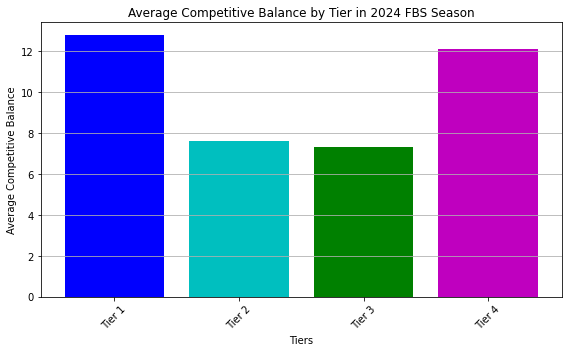

In [1301]:
viz = pd.DataFrame({
    'Tier 1': [average_CBR],
    'Tier 2': [average_CBR2],
    'Tier 3': [average_CBR3],
    'Tier 4': [average_CBR4]
})    

viz

viz = viz.T
viz.columns = ['Average CBR']  # Rename the column for clarity

# Create the bar chart
plt.figure(figsize=(8, 5))
plt.bar(viz.index, viz['Average CBR'], color=['blue', 'c', 'green', 'm'])
plt.title('Average Competitive Balance by Tier in 2024 FBS Season')
plt.xlabel('Tiers')
plt.ylabel('Average Competitive Balance')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y')  # Add gridlines for better visibility
plt.tight_layout()  # Adjust layout to fit labels

# Show the plot
plt.show()

## Creates 2024 ELO Rankings

In [1275]:
final_results['Tier'] = "Tier 1"
final_results2['Tier'] = "Tier 2"
final_results3['Tier'] = "Tier 3"
final_results4['Tier'] = "Tier 4"

cfb24 = pd.concat([final_results, final_results2, final_results3, final_results4], ignore_index=True)

cfb24

,Team,Wins,Losses,Starting ELO,Week 12 ELO,Starting Rank,Week 12 Rank,Tier
0,Georgia,9,3,1764.200000,1853.0,1,1,Tier 1
1,Oregon,8,4,1709.700000,1836.0,4,2,Tier 1
2,Michigan,7,5,1743.400000,1808.0,2,3,Tier 1
3,Notre Dame,7,5,1668.866667,1725.0,12,6,Tier 1
4,Tennessee,7,5,1668.933333,1714.0,11,8,Tier 1
...,...,...,...,...,...,...,...,...
129,Colorado State,4,8,1433.900000,1338.0,9,26,Tier 4
130,UTEP,4,8,1380.433333,1276.0,23,30,Tier 4
131,UMass,5,7,1330.500000,1283.0,30,29,Tier 4
132,Louisiana Tech,3,9,1370.000000,1200.0,26,32,Tier 4


In [1292]:
# sort by elo
pre25 = cfb24.sort_values(by='Week 12 ELO', ascending=False)
pre25 = pre25.rename(columns={'Week 12 ELO': 'ELO'})
pre25 = pre25.rename(columns={'Tier': '2024 Tier'})
pre25 = pre25.drop(columns=['Starting ELO', 'Week 12 Rank','Starting Rank','Wins','Losses'])
pre25.reset_index(drop=True, inplace=True)

pre25['Tier'] = ''  # Initialize the new column

# Assign values based on row indices
pre25.loc[:33, 'Tier'] = 'Tier 1'       # First 34 rows (0 to 33)
pre25.loc[34:67, 'Tier'] = 'Tier 2'     # Next 34 rows (34 to 67)
pre25.loc[68:101, 'Tier'] = 'Tier 3'    # Next 34 rows (68 to 101)
pre25.loc[102:, 'Tier'] = 'Tier 4'      # Last 32 rows (102 to end)

preseason25 = pre25


tier1 = pre25.head(34)
tier1.reset_index(drop=True, inplace=True)
pre25 = pre25.tail(100)


tier2 = pre25.head(34)
tier2.reset_index(drop=True, inplace=True)
pre25 = pre25.tail(66)


tier3 = pre25.head(34)
tier3.reset_index(drop=True, inplace=True)
pre25 = pre25.tail(32)


tier4 = pre25.head(32)
tier4.reset_index(drop=True, inplace=True)

preseason25 = preseason25.drop(columns=['Tier'])

preseason25 = preseason25.head(10)


preseason25


,Team,ELO,2024 Tier
0,Georgia,1853.0,Tier 1
1,Oregon,1836.0,Tier 1
2,Michigan,1808.0,Tier 1
3,Oklahoma,1748.0,Tier 1
4,Kentucky,1742.0,Tier 2
5,Troy,1730.0,Tier 1
6,Washington,1725.0,Tier 1
7,Notre Dame,1725.0,Tier 1
8,Tennessee,1714.0,Tier 1
9,Kansas State,1701.0,Tier 1


In [1291]:
preseason25.to_csv('preseason25.csv', index=False)